# DataSet

The Hylleraas Software Platform (HSP) `DataSet` object is a container used for storing and manipulating chemical simulation data. Both in terms of input information *for* simulations, such as chemical structures and molecular geometries, and output information *from* simulations, such as energies, gradients, and other properties. 

The HSP `DataSet` wraps and extends the `pandas.DataFrame` object, providing a number of additional features and methods for working with chemical simulation data.

In the following tutorial, we will consider (a subset of) the [QM9 dataset](https://www.nature.com/articles/sdata201422), performing xTB calculations and comparing the results to the reference data. We will demonstrate how to use the `DataSet` object to store and manipulate the data, and how the simulations can be run on supercomputing clusters.

<a id='install_note'></a>

```{eval-rst}
.. admonition:: Note

   This guide requires the *Hylleraas Software Platform* to be installed. Please refer to :ref:`installation` for information about how to install the HSP.

   This guide also requires the xTB software to be installed. Please refer to :ref:`quantum_chemistry_codes` for information about how to install xTB.

   Normally, **all** necessary software for this tutorial may be installed by running the following commands in the terminal:

    .. code-block:: bash

        python3 -m pip install git+https://gitlab.com/hylleraasplatform/hylleraas.git
        python3 -m pip install ipywidgets numpy matplotlib pandas

        conda create -n conda_xtb
        conda install -c conda-forge -n conda_xtb xtb

   In order to execute the part of this guide which pertains to running calculations on remote supercomputing clusters, you will need to have access to a server on which xTB is installed (or install it yourself *on* the server).
```


## Prerequisites
First, we will download the QM9 dataset and prepare the data for the tutorial. The QM9 dataset is a large dataset of small organic molecules, containing about 134&thinsp;000 molecules and 19 properties for each molecule. We will use a subset of the dataset containing 100 molecules. 

To download the QM9 dataset in .CSV format, run the following command in the terminal:
```bash
curl -L -o qm9.csv https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv
```

## Loading the data: Our first `DataSet`
We will start by loading the QM9 dataset into a `DataSet` object. The HSP `DataSet` can read from .CSV files like any other `pandas.DataFrame`. The QM9 dataset contains data about the following properties for each molecule:

| Property Index | Property    | Unit             | Description |
|----------------|-------------|------------------|-------------|
| 1              | `mol_id`    |                  | The (internal) molecule ID for the dataset |
| 2              | `smiles`    |                  | The SMILES string representation of the molecule |
| 3              | `A`         | GHz              | Rotational constant A |
| 4              | `B`         | GHz              | Rotational constant B |
| 5              | `C`         | GHz              | Rotational constant C |
| 6              | `mu`        | Bohr<sup>3</sup> | Dipole moment |
| 7              | `alpha`     | Bohr<sup>3</sup> | Isotropic polarizability |
| 8              | `homo`      | Hartree          | Energy of the highest occupied molecular orbital |
| 9              | `lumo`      | Hartree          | Energy of the lowest unoccupied molecular orbital |
| 10             | `gap`       | Hartree          | Difference between the HOMO and the LUMO |
| 11             | `r2`        | Bohr<sup>2</sup> | Electonic spatial extent |
| 12             | `zpve`      | Hartree          | Zero point vibrational energy |
| 13             | `u0`        | Hartree          | Internal energy at 0 K |
| 14             | `u298`      | Hartree          | Internal energy at 298.15 K |
| 15             | `h298`      | Hartree          | Enthalpy at 298.15 K |
| 16             | `g298`      | Hartree          | Free energy at 298.15 K |
| 17             | `cv`        | cal / (mol K)    | Heat capacity at 298.15 K |
| 18             | `u0_atom`   | kcal / mol       | Atomization energy at 0 K |
| 19             | `u298_atom` | kcal / mol       | Atomization energy at 298.15 K |
| 20             | `h298_atom` | kcal / mol       | Atomization enthalpy at 298.15 K |
| 21             | `g298_atom` | kcal / mol       | Atomization free energy at 298.15 K |

Let us load this data into our `DataSet` and inspect it.

In [69]:
import hylleraas as hsp
import ipywidgets
import copy
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [11]:
# Load the dataset from the file qm9.csv
ds = hsp.DataSet("qm9.csv", units=hsp.Units("atomic"))

# Inspect the first few rows of the dataset
ds.data.head()

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,gdb_1,C,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,...,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772
1,gdb_2,N,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,...,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802
2,gdb_3,O,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,...,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171
3,gdb_4,C#C,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,...,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,-385.501997,-387.237686,-389.016047,-365.800724
4,gdb_5,C#N,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,...,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278,-301.820534,-302.906752,-304.091489,-288.720028


### Pruning the `DataSet`
We will only consider a small subset of the total QM9 data in this tutorial. Both in terms of the number of molecules, *and* in terms of the number of properties we will consider. We can find the size of the dataset by calling e.g. `dataset.shape` or `len(dataset)`.

In [13]:
# BUG: https://gitlab.com/hylleraasplatform/hyobj/-/blob/main/hyobj/dataset/dataset.py?ref_type=heads#L688
# TODO: Remove the if test and remove this line when the bug is fixed
ds.data_type = "pandas"

ds.shape

(200, 21)

In [14]:
len(ds)

200

Individual rows of the dataset may be accessed using simple indexing, e.g. `dataset[0]` or `dataset[127]`.

In [15]:
ds[0]

DataSet(debug=False, _units=Units({'style': 'atomic', 'mass': Quantity(unit='electron_mass', value=1.0, symbol='me'), 'energy': Quantity(unit='hartree', value=1.0, symbol='Eh'), 'length': Quantity(unit='bohr', value=1.0, symbol='a0'), 'time': Quantity(unit='femtoseconds', value=1.0, symbol='fs'), 'force': Quantity(unit='hartree/bohr', value=1.0, symbol='Eh/a0'), 'hessian': Quantity(unit='hartree/bohr**2', value=1.0, symbol='Eh/a0**2')}), data=  mol_id smiles         A          B          C   mu  alpha    homo    lumo  \
0  gdb_1      C  157.7118  157.70997  157.70699  0.0  13.21 -0.3877  0.1171   

      gap  ...      zpve        u0       u298       h298       g298     cv  \
0  0.5048  ...  0.044749 -40.47893 -40.476062 -40.475117 -40.498597  6.469   

      u0_atom  u298_atom   h298_atom   g298_atom  
0 -395.999595 -398.64329 -401.014647 -372.471772  

[1 rows x 21 columns], properties={'units': Units({'style': 'atomic', 'mass': Quantity(unit='electron_mass', value=1.0, symbol='me'), 

In [16]:
ds[127]

DataSet(debug=False, _units=Units({'style': 'atomic', 'mass': Quantity(unit='electron_mass', value=1.0, symbol='me'), 'energy': Quantity(unit='hartree', value=1.0, symbol='Eh'), 'length': Quantity(unit='bohr', value=1.0, symbol='a0'), 'time': Quantity(unit='femtoseconds', value=1.0, symbol='fs'), 'force': Quantity(unit='hartree/bohr', value=1.0, symbol='Eh/a0'), 'hessian': Quantity(unit='hartree/bohr**2', value=1.0, symbol='Eh/a0**2')}), data=      mol_id  smiles         A        B        C      mu  alpha    homo  \
127  gdb_128  CCCC=O  20.60318  2.12564  2.08237  2.7552  47.03 -0.2487   

       lumo     gap  ...      zpve         u0        u298        h298  \
127 -0.0195  0.2292  ...  0.112697 -232.36363 -232.357283 -232.356339   

          g298      cv      u0_atom    u298_atom    h298_atom    g298_atom  
127 -232.39356  20.766 -1198.403511 -1205.974407 -1213.087849 -1117.809392  

[1 rows x 21 columns], properties={'units': Units({'style': 'atomic', 'mass': Quantity(unit='electro

Slicing can be used to extract a subset of the *rows* in the dataset, e.g. `dataset[:10]` or `dataset[100:200]`. Let us use it to take the first 100 molecules from the dataset. This will be our reference data.

In [17]:
reference = ds[:100]
reference.data.head(100)

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,gdb_1,C,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,...,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772
1,gdb_2,N,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,...,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802
2,gdb_3,O,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,...,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171
3,gdb_4,C#C,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,...,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,-385.501997,-387.237686,-389.016047,-365.800724
4,gdb_5,C#N,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,...,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278,-301.820534,-302.906752,-304.091489,-288.720028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,gdb_96,CC1CCO1,9.93129,4.563620,3.637040,1.6826,45.72,-0.2410,0.0915,0.3325,...,0.114590,-232.331230,-232.325877,-232.324933,-232.359589,18.582,-1178.072219,-1186.266859,-1193.380301,-1096.492284
96,gdb_97,CC1COC1,10.13697,4.325120,3.509120,1.8995,45.45,-0.2419,0.0814,0.3233,...,0.114694,-232.325947,-232.320548,-232.319604,-232.354576,18.443,-1174.757089,-1182.922863,-1190.036306,-1093.346581
97,gdb_98,C1CC(C1)O,10.09703,4.268650,3.404870,1.4604,45.55,-0.2560,0.0801,0.3361,...,0.115063,-232.333258,-232.328097,-232.327153,-232.361103,19.023,-1179.344807,-1187.659929,-1194.773371,-1097.442332
98,gdb_99,C1C(CO1)O,10.85394,4.528670,3.623280,2.4158,38.58,-0.2465,0.0604,0.3069,...,0.091005,-268.248371,-268.243234,-268.242290,-268.276572,17.344,-989.744218,-996.296667,-1002.224117,-921.180074


### Extracting certain columns
To simplify our tutorial, we will only consider a small number of properties for each molecule. We will remove columns from the dataset pertaining to properties we are not interested in. This can be done using the `dataset.drop` method. We will keep only the `mol_id`, `smiles`, `gap`, and `u0` columns.

In [18]:
reference.data.columns

Index(['mol_id', 'smiles', 'A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap',
       'r2', 'zpve', 'u0', 'u298', 'h298', 'g298', 'cv', 'u0_atom',
       'u298_atom', 'h298_atom', 'g298_atom'],
      dtype='object')

In [19]:
reference.data

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,gdb_1,C,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,...,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772
1,gdb_2,N,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,...,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802
2,gdb_3,O,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,...,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171
3,gdb_4,C#C,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,...,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,-385.501997,-387.237686,-389.016047,-365.800724
4,gdb_5,C#N,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,...,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278,-301.820534,-302.906752,-304.091489,-288.720028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,gdb_96,CC1CCO1,9.93129,4.563620,3.637040,1.6826,45.72,-0.2410,0.0915,0.3325,...,0.114590,-232.331230,-232.325877,-232.324933,-232.359589,18.582,-1178.072219,-1186.266859,-1193.380301,-1096.492284
96,gdb_97,CC1COC1,10.13697,4.325120,3.509120,1.8995,45.45,-0.2419,0.0814,0.3233,...,0.114694,-232.325947,-232.320548,-232.319604,-232.354576,18.443,-1174.757089,-1182.922863,-1190.036306,-1093.346581
97,gdb_98,C1CC(C1)O,10.09703,4.268650,3.404870,1.4604,45.55,-0.2560,0.0801,0.3361,...,0.115063,-232.333258,-232.328097,-232.327153,-232.361103,19.023,-1179.344807,-1187.659929,-1194.773371,-1097.442332
98,gdb_99,C1C(CO1)O,10.85394,4.528670,3.623280,2.4158,38.58,-0.2465,0.0604,0.3069,...,0.091005,-268.248371,-268.243234,-268.242290,-268.276572,17.344,-989.744218,-996.296667,-1002.224117,-921.180074


In [20]:
reference.data.drop(
    [
        "A",
        "B",
        "C",
        "mu",
        "alpha",
        "homo",
        "lumo",
        "r2",
        "zpve",
        "u298",
        "h298",
        "g298",
        "cv",
        "u0_atom",
        "u298_atom",
        "h298_atom",
        "g298_atom",
    ],
    inplace=True,
    axis=1,
)

/var/folders/js/w1m65s9d371f4z6l71rjgn200000gn/T/ipykernel_21634/209270271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reference.data.drop(


Inspecting the dataset now shows a more manageable size. This will serve as our reference data for the tutorial.

In [21]:
reference.data

,mol_id,smiles,gap,u0
0,gdb_1,C,0.5048,-40.478930
1,gdb_2,N,0.3399,-56.525887
2,gdb_3,O,0.3615,-76.404702
3,gdb_4,C#C,0.3351,-77.308427
4,gdb_5,C#N,0.3796,-93.411888
...,...,...,...,...
95,gdb_96,CC1CCO1,0.3325,-232.331230
96,gdb_97,CC1COC1,0.3233,-232.325947
97,gdb_98,C1CC(C1)O,0.3361,-232.333258
98,gdb_99,C1C(CO1)O,0.3069,-268.248371


## `DataSet` objects and HSP calculations
The `DataSet` object is a powerful tool for working with chemical simulation data. It can be used to handle running of large numbers of simulations, and to store the results of these simulations. 

In order to run simulations with the Hylleraas Software Platform (HSP), we first need to create `Molecule` objects repsenting a single molecule. We can create molecules from each row in the `DataSet` using the `DataSet.systems()`. This will return a list of `Molecule` objects, one for each row in the `DataSet`.

In [22]:
# TODO: https://gitlab.com/hylleraasplatform/hyobj/-/blob/main/hyobj/dataset/dataset.py?ref_type=heads#L322-390
# TODO: Support SMILES string generation in hyobj.DataSet.systems

from typing import List


def systems(columns, data, _units) -> List:
    """Get molecules from DataSet."""
    from hyobj import Molecule, PeriodicSystem

    unit_cell_keys = ['unit_cell', 'cell', 'cells', 'box', 'boxes', 'pbc']
    coordinates_keys = [
        'coordinates',
        'coords',
        'coord',
        'pos',
        'positions',
        'position',
    ]
    atoms_keys = [
        'atoms',
        'atom',
        'species',
        'species_labels',
        'species_label',
    ]
    smiles_keys = [
        'smiles', 
        'SMILES',
    ]

    systems = []
    # columns = self.data.columns

    smiles_key = None
    for key in smiles_keys:
        if key in columns:
            smiles_key = key
    if smiles_key is not None:
        for _, row in data.iterrows():
            systems.append(
                Molecule(
                    row[smiles_key],
                    units=_units,
                )
            )
        return systems
    
    atoms_key = None
    for key in atoms_keys:
        if key in columns:
            atoms_key = key
            break
    if atoms_key is None:
        raise ValueError('could not find atoms key')

    coordinates_key = None
    for key in coordinates_keys:
        if key in columns:
            coordinates_key = key
            break
    if coordinates_key is None:
        raise ValueError('could not find coordinates key')

    unit_cell_key = None
    for key in unit_cell_keys:
        if key in columns:
            unit_cell_key = key
            break

    
    for _, row in data.iterrows():
        coordinates = row[coordinates_key]
        atoms = row[atoms_key]
        if unit_cell_key is not None:
            unit_cell = row[unit_cell_key]
            systems.append(
                PeriodicSystem(
                    {
                        'atoms': atoms,
                        'coordinates': coordinates,
                        'pbc': unit_cell,
                    },
                    units=_units,
                )
            )  # type: ignore
        else:
            systems.append(
                Molecule(  # type: ignore
                    {'atoms': atoms, 'coordinates': coordinates},
                    units=_units,
                )
            )
    return systems


reference.systems_ = systems

In [42]:
# BUG: Cannot create Molecule object with units for any other choice than "angstrom"
# TODO: Fix https://gitlab.com/hylleraasplatform/hyobj/-/issues/9
mol = hsp.Molecule("O", units=hsp.Units("atomic"))

TypeError: units changed, properties might be inconsistent

In [23]:
molecules = reference.systems_(reference.data.columns, reference.data, reference._units)

TypeError: units changed, properties might be inconsistent

In [43]:
# TODO: Remove when previous cell works after https://gitlab.com/hylleraasplatform/hyobj/-/issues/10 is fixed.

molecules = [hsp.Molecule(s) for s in reference.data["smiles"].tolist()]

### Visualizing `Molecule`s
We can now inspect the starting structure generated from the SMILES strings in the dataset. We can use the `Molecule` object to visualize the structure of the molecule, and to inspect the SMILES string.

In [44]:
hsp.view_molecule(molecules[27]);

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Some `ipywidgets` magic can get us an interactive viewer for the molecules in the reference dataset.

In [45]:

def interactive_show(index):
    hsp.view_molecule(molecules[index])

play = ipywidgets.Play(value=0, min=0, max=99, interval=2500, disabled=False)
slider = ipywidgets.IntSlider(min=0, max=99, step=1, description="C")

def on_value_change(change):
    slider.description = f"{reference.data.iloc[change.new]['smiles']}"

slider.observe(on_value_change, "value")
ipywidgets.jslink((play, "value"), (slider, "value"))
display(slider)
ipywidgets.interact(interactive_show, index=play)

IntSlider(value=0, description='C', max=99)

interactive(children=(Play(value=0, description='index', interval=2500, max=99), Output()), _dom_classes=('wid…

### Removing certain rows
In order to ease the molecule identification later on, we will keep only molecules in the reference dataset which correspond to unique atomic compositions. For example, QM9 index 11: [Acetaldehyde](https://en.wikipedia.org/wiki/Acetaldehyde) (SMILES string: `CC=O`) and QM9 index 17: [Ethylene oxide](https://en.wikipedia.org/wiki/Ethylene_oxide) (SMILES string: `C1CO1`) both share the chemical formula C<sub>2</sub>H<sub>4</sub>O. Although they represent different molecules, we will keep only one of them in our reference dataset.

In [46]:
# TODO: https://gitlab.com/hylleraasplatform/hyobj/-/blob/main/hyobj/dataset/dataset.py?ref_type=heads#L836-909
# TODO: Update get_duplicates to handle lists with different lengths
# 
# BUG: Does not handle dataframes with non-contiguous indices, i.e. after 
# BUG: dropping duplicate rows once, this will fail

from typing import Optional
import pandas as pd
import numpy as np


def get_duplicates(
    col: pd.Series,
    rtol: Optional[float] = 1e-05,
    atol: Optional[float] = 1e-08,
) -> list:
    """Get duplicates in column.

    Parameter
    ---------
    col: pandas.Series
        column
    rtol: float, optional
        rtol as used by numpy.allclose, default 1e-05
    atol: float, optional
        atol as used by numpy.allclose, default 1e-08

    Returns
    -------
    list
        list of (tuples) of duplicates

    """
    if col.dtype == 'object':
        if all(isinstance(col[i], str) for i in range(len(col))):
            s = pd.Series(col, dtype=pd.StringDtype()).duplicated(
                keep='first'
            )
            duplicates = s[s].index.values
        elif all(isinstance(col[i], np.ndarray) for i in range(len(col))):
            alist = [np.array(item,
                                dtype=np.float64).ravel() for item in col]
            duplicates = [(i, j) for i in range(len(col))
                            for j in range(i + 1, len(col))
                            if np.allclose(alist[i],
                                            alist[j],
                                            rtol=rtol,
                                            atol=atol)]

        elif all(isinstance(col[i], list) for i in range(len(col))):
            if all(len(col[i]) == len(col[0]) for i in range(len(col))):
                duplicates = [
                    (i, j) for i in range(len(col)) for j in range(i + 1, len(col))
                    if all(col[i][k] == col[j][k] for k in range(len(col[i])))
                ]
            else:
                duplicates = []
                for i in range(len(col)):
                    for j in range(i + 1, len(col)):
                        if col[i] == col[j]:
                            duplicates.append((i, j))
        else:
            raise TypeError(
                'duplicate comparison currently only allowed for '
                + f'{type(str), } {type(list)} and {type(np.ndarray)}'
            )

    return duplicates


reference.get_duplicates = get_duplicates
        

In [48]:
reference.data.insert(4, "atoms", ["".join(m._atoms) for m in molecules])

In [49]:
duplicates = reference.get_duplicates(reference.data["atoms"])
reference.data.drop(index=duplicates, inplace=True)
reference.data.head(100)

/var/folders/js/w1m65s9d371f4z6l71rjgn200000gn/T/ipykernel_21634/3945742013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reference.data.drop(index=duplicates, inplace=True)


,mol_id,smiles,gap,u0,atoms
0,gdb_1,C,0.5048,-40.478930,CHHHH
1,gdb_2,N,0.3399,-56.525887,NHHH
2,gdb_3,O,0.3615,-76.404702,OHH
3,gdb_4,C#C,0.3351,-77.308427,CCHH
4,gdb_5,C#N,0.3796,-93.411888,CNH
...,...,...,...,...,...
85,gdb_86,CC1(CC1)C,0.3526,-196.409349,CCCCCHHHHHHHHHH
88,gdb_89,N=C1CCO1,0.2907,-247.201165,NCCCOHHHHH
89,gdb_90,C1CC(=O)C1,0.2222,-231.155780,CCCOCHHHHHH
90,gdb_91,C1CNC1=O,0.2880,-247.225618,CCNCOHHHHH


Let us finally prune the `molecules` list we created earlier to include only the molecules in the reduced reference set. First we reindex the `DataSet`, ensuring the `DataFrame` index is contigouous monotonically increasing to make it more conveinent to work with. Note that the previous index&mdash;corresponding to the QM9 index&mdash;is stored in a new column now called `index`.

In [50]:
reference.data.reset_index(inplace=True, drop=False)
reference.data.head(100)

,index,mol_id,smiles,gap,u0,atoms
0,0,gdb_1,C,0.5048,-40.478930,CHHHH
1,1,gdb_2,N,0.3399,-56.525887,NHHH
2,2,gdb_3,O,0.3615,-76.404702,OHH
3,3,gdb_4,C#C,0.3351,-77.308427,CCHH
4,4,gdb_5,C#N,0.3796,-93.411888,CNH
...,...,...,...,...,...,...
72,85,gdb_86,CC1(CC1)C,0.3526,-196.409349,CCCCCHHHHHHHHHH
73,88,gdb_89,N=C1CCO1,0.2907,-247.201165,NCCCOHHHHH
74,89,gdb_90,C1CC(=O)C1,0.2222,-231.155780,CCCOCHHHHHH
75,90,gdb_91,C1CNC1=O,0.2880,-247.225618,CCNCOHHHHH


## Running calculations on the `Molecule`s
Let us now run some simulations on the molecules in the reference dataset. We will use the xTB software to calculate the energies and gradients of the molecules. For a more in-depth guide on how to use xTB with the HSP, please refer to the `QUICKSTART GUIDE LINK HERE`.

In [51]:
# Define the compute settings for running xTB in the conda environment we setup
# earlier
xtb_conda_settings = hsp.create_compute_settings(
    "conda", 
    conda_env="conda_xtb",
    work_dir="xtb_conda_simulations",
)

# Define the HSP xTB method object
xtb_method = hsp.Xtb(
    {
        # calculate energy, gradients, and perform a geometry optimization
        "properties": ["energy", "geometry_optimization", "gradient"],  
    },
    compute_settings=xtb_conda_settings,
    units=hsp.Units("atomic"),
)

A single xTB calculation may now be run by picking out one of the `Molecule` objects from the list, and calling the `.run()` method from `xtb_method`.

In [52]:
result_0 = xtb_method.run(molecules[0])
print(result_0)

{'xtbopt.xyz': '5\n energy: -4.175218289350 gnorm: 0.000359683898 xtb: 6.6.1 (8d0f1dd)\nC           -0.00015654817627        0.00007121354402       -0.00010985227481\nH            0.52742168077821        0.74358830513502       -0.58356844346293\nH            0.71197963169963       -0.58317003458969        0.56899242241239\nH           -0.55343963426943       -0.65313148358235       -0.66265592159449\nH           -0.68580513003213        0.49264199949299        0.67734179491984\n', 'final_geometry': [[-0.00015654817627, 7.121354402e-05, -0.00010985227481], [0.52742168077821, 0.74358830513502, -0.58356844346293], [0.71197963169963, -0.58317003458969, 0.56899242241239], [-0.55343963426943, -0.65313148358235, -0.66265592159449], [-0.68580513003213, 0.49264199949299, 0.67734179491984]], 'input_geometry': array([[ 0.005119, -0.01062 ,  0.006014],
       [ 0.549668,  0.755438, -0.596981],
       [ 0.749764, -0.587944,  0.585285],
       [-0.586753, -0.652136, -0.676092],
       [-0.717798,  0

The result object is returned right here in the notebook. If we want to inspect the result files from the simulation directly, we may find them inside the `work_dir` directory we defined in the computational settings earlier.

```bash
$ tree
├── dataset.ipynb
├── qm9.csv
├── xtb_conda_simulations
│   ├── ee0a1806e18a850dc9811e5c7def32220d04d00aefa81e6b3f3509b1202264a9
│   │   ├── charges
│   │   ├── ee0a1806e18a850dc9811e5c7def32220d04d00aefa81e6b3f3509b1202264a9.engrad
│   │   ├── ee0a1806e18a850dc9811e5c7def32220d04d00aefa81e6b3f3509b1202264a9.out
│   │   ├── ee0a1806e18a850dc9811e5c7def32220d04d00aefa81e6b3f3509b1202264a9.stderr
│   │   ├── ee0a1806e18a850dc9811e5c7def32220d04d00aefa81e6b3f3509b1202264a9.xyz
│   │   ├── energy
│   │   ├── gradient
│   │   ├── wbo
│   │   ├── xtbopt.log
│   │   ├── xtbopt.xyz
│   │   ├── xtbrestart
│   │   └── xtbtopo.mol
│   ├── stderr.out
│   └── xtb_version.out
```

Each simulation will be placed in a subdirectory named after the simulation's (molecule and simulation method details) *hash*. This is a string containing a 65-digit hexadecimal number, acting as a unique identifier for the calculation. 

### Running multiple calculations

#### Sequential `run`s
There are two main ways to run multiple simulations with the HSP. One way is sequentially. This may be done simply by providing the run method with a list of `Molecule` objects.

In [53]:
result_0_to_5 = xtb_method.run(molecules[0:5])

#### Concurrent `arun`s
The other way is to perform the calculations in parallel. This is done with the `.arun()` method of the xTB method object. As `.arun()` is an asynchronous method, we need to `await` the result with `asyncio`.

In [54]:
import asyncio

results_0_to_10 = await asyncio.gather(*[xtb_method.arun(m) for m in molecules[:10]]) 

Note that all simulations are *cached*, meaning that any starting simulation will first check if the result has already been calculated and stored. If so, the result will be immediately returned. We can demonstrate this by now running the xTB calculations for the first ten molecules again, and observing that the results will be instantaneously returned.

In [55]:
results_recomputed = xtb_method.run(molecules[:10])

## `DataSet` objects and HSP results
Let us now create an HSP `DataSet` from the results of the xTB calculations.

In [56]:
testset = hsp.DataSet(
    Path.cwd().resolve() / "xtb_conda_simulations",
    parser=xtb_method.OutputParser,
)
testset.data.columns

Index(['version', 'cite', 'omp_threads', 'Reference', 'basis_functions',
       'atomic_orbitals', 'electrons', 'iterations', 'fermi_level', 'energy',
       'homo_lumo_gap', 'geometry_iterations', 'orbital_energies',
       'orbital_occupations', 'orbital_homo', 'orbital_lumo',
       'coordination_numbers', 'molecular_dipole', 'molecular_quadrupole',
       'molecular_quadrupole_order', 'gradient_norm', 'gradient',
       'input_geometry', 'atoms', 'xtbopt.xyz', 'final_geometry'],
      dtype='object')

As with the reference dataset earlier, this new test set contains a lot of properties we are not interested in right now (such as the version number of xTB used to run the simulations, the DOI of the xTB software paper, etc.). We can use the `dataset.drop` method to remove these columns from the dataset.

However, it is easier to just read in only the data we care about when we create the `DataSet` object. We can do this by providing the `keys=` keyword argument to the `DataSet` constructor. This will only read in the columns we specify.

In [60]:
testset = hsp.DataSet(
    Path.cwd().resolve() / "xtb_conda_simulations",
    parser=xtb_method.OutputParser,
    keys=[
        "energy", 
        "homo_lumo_gap",
        "atoms",
        "final_geometry",
    ],
    units=hsp.Units("atomic"),
)

# Convert the "atoms" column to a string from a list
testset.data["atoms"] = testset.data["atoms"].apply(lambda s: ''.join(s))
testset.data

,energy,homo_lumo_gap,atoms,final_geometry
0,-5.206769,7.288901,CCHH,"[[-0.56211563647059, 0.23910764565559, 0.02689..."
1,-7.336371,15.504792,CCHHHHHH,"[[-0.7603170246353, 0.01769692838875, 0.017796..."
2,-7.175648,3.620081,COHH,"[[0.00078145605603, -0.00013842954601, -0.0001..."
3,-5.070544,14.381636,OHH,"[[-0.00024349594891, 0.37994936981825, 0.0], [..."
4,-5.504063,5.948841,CNH,"[[-0.02069976821768, -0.34939553451093, -0.0],..."
5,-8.382907,7.080212,CCCHHHH,"[[-0.94081333309376, 0.14274919428681, 0.00082..."
6,-4.426244,12.229820,NHHH,"[[0.00222253356455, -0.00019656410115, 0.27501..."
7,-8.688500,6.110333,CCNHHH,"[[-0.48653032543673, 0.02885077880477, -0.0031..."
8,-8.226118,13.090922,COHHHH,"[[-0.36220929111903, -0.02428303744012, -0.015..."
9,-4.175218,17.341170,CHHHH,"[[-0.00015654817627, 7.121354402e-05, -0.00010..."


Let us make a copy of the reference `DataSet` containing only the first ten molecules.

In [61]:
reference_10 = copy.deepcopy(reference[:10])
reference_10.data

,index,mol_id,smiles,gap,u0,atoms
0,0,gdb_1,C,0.5048,-40.478930,CHHHH
1,1,gdb_2,N,0.3399,-56.525887,NHHH
2,2,gdb_3,O,0.3615,-76.404702,OHH
3,3,gdb_4,C#C,0.3351,-77.308427,CCHH
4,4,gdb_5,C#N,0.3796,-93.411888,CNH
5,5,gdb_6,C=O,0.2263,-114.483613,COHH
6,6,gdb_7,CC,0.4426,-79.764152,CCHHHHHH
7,7,gdb_8,CO,0.3437,-115.679136,COHHHH
8,8,gdb_9,CC#C,0.3222,-116.609549,CCCHHHH
9,9,gdb_10,CC#N,0.3640,-132.718150,CCNHHH


Now we can merge the test and reference datasets together using ...

In [62]:
reference_10.append(testset, options={"on": "atoms"})
reference_10.data.head(10)

,energy,homo_lumo_gap,atoms,final_geometry,index,mol_id,smiles,gap,u0
0,-4.175218,17.341170,CHHHH,"[[-0.00015654817627, 7.121354402e-05, -0.00010...",0,gdb_1,C,0.5048,-40.478930
1,-4.426244,12.229820,NHHH,"[[0.00222253356455, -0.00019656410115, 0.27501...",1,gdb_2,N,0.3399,-56.525887
2,-5.070544,14.381636,OHH,"[[-0.00024349594891, 0.37994936981825, 0.0], [...",2,gdb_3,O,0.3615,-76.404702
3,-5.206769,7.288901,CCHH,"[[-0.56211563647059, 0.23910764565559, 0.02689...",3,gdb_4,C#C,0.3351,-77.308427
4,-5.504063,5.948841,CNH,"[[-0.02069976821768, -0.34939553451093, -0.0],...",4,gdb_5,C#N,0.3796,-93.411888
5,-7.175648,3.620081,COHH,"[[0.00078145605603, -0.00013842954601, -0.0001...",5,gdb_6,C=O,0.2263,-114.483613
6,-7.336371,15.504792,CCHHHHHH,"[[-0.7603170246353, 0.01769692838875, 0.017796...",6,gdb_7,CC,0.4426,-79.764152
7,-8.226118,13.090922,COHHHH,"[[-0.36220929111903, -0.02428303744012, -0.015...",7,gdb_8,CO,0.3437,-115.679136
8,-8.382907,7.080212,CCCHHHH,"[[-0.94081333309376, 0.14274919428681, 0.00082...",8,gdb_9,CC#C,0.3222,-116.609549
9,-8.688500,6.110333,CCNHHH,"[[-0.48653032543673, 0.02885077880477, -0.0031...",9,gdb_10,CC#N,0.3640,-132.718150


We can rename some columns to make the data easier to keep track of.

In [63]:
data_10 = copy.deepcopy(reference_10)
data_10.rename_columns(
    {
        "energy": "xtb_energy",
        "u0": "reference_energy",
        "homo_lumo_gap": "xtb_gap",
        "gap": "reference_gap",
    }
)

     energy  homo_lumo_gap     atoms  \
0 -4.175218      17.341170     CHHHH   
1 -4.426244      12.229820      NHHH   
2 -5.070544      14.381636       OHH   
3 -5.206769       7.288901      CCHH   
4 -5.504063       5.948841       CNH   
5 -7.175648       3.620081      COHH   
6 -7.336371      15.504792  CCHHHHHH   
7 -8.226118      13.090922    COHHHH   
8 -8.382907       7.080212   CCCHHHH   
9 -8.688500       6.110333    CCNHHH   

                                      final_geometry  index  mol_id smiles  \
0  [[-0.00015654817627, 7.121354402e-05, -0.00010...      0   gdb_1      C   
1  [[0.00222253356455, -0.00019656410115, 0.27501...      1   gdb_2      N   
2  [[-0.00024349594891, 0.37994936981825, 0.0], [...      2   gdb_3      O   
3  [[-0.56211563647059, 0.23910764565559, 0.02689...      3   gdb_4    C#C   
4  [[-0.02069976821768, -0.34939553451093, -0.0],...      4   gdb_5    C#N   
5  [[0.00078145605603, -0.00013842954601, -0.0001...      5   gdb_6    C=O   
6  [[-0.76031

KeyError: 'energy'

In [66]:
# TODO: It seems neccessary to set the "column_units" property, or this renameing 
# straight up fails

data_10.properties["column_units"] = {
    k: hsp.Units("atomic") for k in ["energy", "u0", "gap", "homo_lumo_gap"]
}
data_10.rename_columns(
    {
        "energy": "xtb_energy",
        "u0": "reference_energy",
        "homo_lumo_gap": "xtb_gap",
        "gap": "reference_gap",
    }
)
data_10.data.head(10)

,xtb_energy,xtb_gap,atoms,final_geometry,index,mol_id,smiles,reference_gap,reference_energy
0,-4.175218,17.341170,CHHHH,"[[-0.00015654817627, 7.121354402e-05, -0.00010...",0,gdb_1,C,0.5048,-40.478930
1,-4.426244,12.229820,NHHH,"[[0.00222253356455, -0.00019656410115, 0.27501...",1,gdb_2,N,0.3399,-56.525887
2,-5.070544,14.381636,OHH,"[[-0.00024349594891, 0.37994936981825, 0.0], [...",2,gdb_3,O,0.3615,-76.404702
3,-5.206769,7.288901,CCHH,"[[-0.56211563647059, 0.23910764565559, 0.02689...",3,gdb_4,C#C,0.3351,-77.308427
4,-5.504063,5.948841,CNH,"[[-0.02069976821768, -0.34939553451093, -0.0],...",4,gdb_5,C#N,0.3796,-93.411888
5,-7.175648,3.620081,COHH,"[[0.00078145605603, -0.00013842954601, -0.0001...",5,gdb_6,C=O,0.2263,-114.483613
6,-7.336371,15.504792,CCHHHHHH,"[[-0.7603170246353, 0.01769692838875, 0.017796...",6,gdb_7,CC,0.4426,-79.764152
7,-8.226118,13.090922,COHHHH,"[[-0.36220929111903, -0.02428303744012, -0.015...",7,gdb_8,CO,0.3437,-115.679136
8,-8.382907,7.080212,CCCHHHH,"[[-0.94081333309376, 0.14274919428681, 0.00082...",8,gdb_9,CC#C,0.3222,-116.609549
9,-8.688500,6.110333,CCNHHH,"[[-0.48653032543673, 0.02885077880477, -0.0031...",9,gdb_10,CC#N,0.3640,-132.718150


### Comparing xTB calculations to reference data

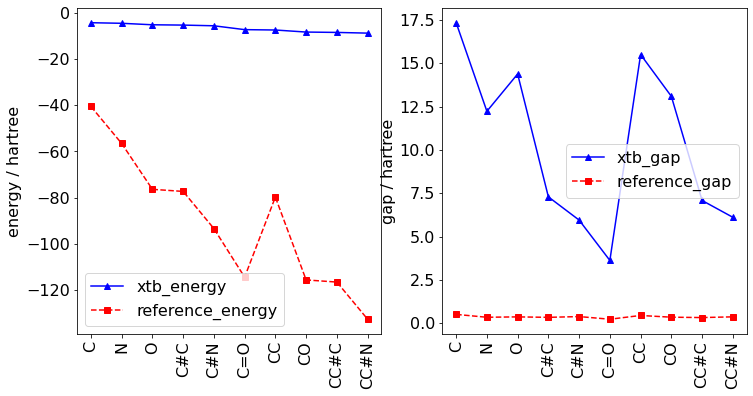

In [90]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax, prop in zip(axs, ["energy", "gap"]):
    for source, style in zip(["xtb", "reference"], ["b^-", "rs--"]):
        ax.plot(
            data_10.data["smiles"].tolist(),
            data_10.data[f"{source}_{prop}"].tolist(),
            style,
            label=f"{source}_{prop}",
        )
        ax.legend()
        ax.set_ylabel(f"{prop} / hartree")
        ax.tick_params(axis='x', labelrotation=90)

## Offload simulations: SLURM servers

### Monitoring job progress

### Batching calculations into a single SLURM job

## Comparing xTB calculations versus the "full" reference data